# Modélisation
## Radiographie Covid-19
### _Asma, Mamaar, Richard_
---

#### Objectif:
L'objectif de cette étape est d'élaborer un modèle capable de classer des radiographies pulmonaire selon trois catégories, Covid, sain et autres (incluant des clichés d'opacité pulmonaire et de pneumonie virale).
La phase de pré-traitement a permis de préparer le terrain en préparant les données afin de les exploiter correctement durant la modélisation. Ainsi, le modèle, basé sur un réseau de neuronnes profond, sera capable d'apprendre à distinguer les différentes pathologies à partir de caractéristiques visuelles présentes sur les images RX.

#### Pré-traitement :
Comme vu précédement, les images ont été redimensionnées à (256 x 256) mais seront probablement redimensionnées au besoin selon le modèle utilisé. Pour cet échantillon, aucune modification aléatoire (rotation, translation, zoom,...) n'a été appliquée afin de préserver l'integrité diagnostiques des images RX, au risque d'altérer des éléments visuels importants. Les images ont, toute fois, été amélioré en terme de contraste et un masque a été appliqué afin de guider le modèle vers la zone à étudier.

#### Choix méthodologiques :
Une approche de transfer learning a été privilégiée pour ce jeu de données. C'est à dire, partir d'un modèle pré-existant déja entrainé pour une tâche similaire. Dans notre cas, cela permettra d'avoir de bonnes performances malgré notre jeu de données limité (3500 images par catégories).

Deux optimiseurs ont été étudiées :
* **InceptionV3 avec SGD**
* **InceptionV3 avec adam**

---

## 1. Transfer learning & InceptionV3 :

In [1]:
# Import des bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling, Resizing, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

Une fois tous les packages utiles importés, nous pouvons charger les données pré-traitées.

In [2]:
# Import des données pré-traitées
train = np.load("train_data_norm.npz")
val = np.load("val_data_norm.npz")
test = np.load("test_data_norm.npz")

X_train = train['X']
y_train = train['y']

X_val = val['X']
y_val = val['y']

X_test = test['X']
y_test = test['y']

mean = train['mean']
std = train['std']

# On passe les images en RGB, necessaire pour le modèle.
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1) if X_train.ndim==3 else np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val[..., np.newaxis], 3, axis=-1) if X_val.ndim==3 else np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1) if X_test.ndim==3 else np.repeat(X_test, 3, axis=-1)

print("Shape de X_train :", X_train.shape)
print("Shape de y_train :", y_train.shape)
print("Shape de X_val :", X_val.shape)
print("Shape de y_val :", y_val.shape)
print("Shape de X_test :", X_test.shape)
print("Shape de y_test :", y_test.shape)
print("Moyenne :", mean)
print("Ecart-type :", std)

Shape de X_train : (7353, 256, 256, 3)
Shape de y_train : (7353,)
Shape de X_val : (1572, 256, 256, 3)
Shape de y_val : (1572,)
Shape de X_test : (1575, 256, 256, 3)
Shape de y_test : (1575,)
Moyenne : 0.10095608
Ecart-type : 0.20103508


Le modèle possède son propre pré-processing et notament sa propre normalisation, par conséquent nous allons déstandardiser nos données afin qu'elles s'adaptent au modèle InceptionV3.

In [3]:
# Déstandardisation des images (car le modèle necessite un autre type de standardisation)
X_train = (X_train*std+mean)*255
X_val = (X_val*std+mean)*255
X_test = (X_test*std+mean)*255
# Vérification :
print("Min train :", X_train.min(),"/ Max train :", X_train.max())
print("Min val :", X_val.min(),"/ Max val :", X_val.max())
print("Min test :", X_test.min(),"/ Max test :", X_test.max())

Min train : 0.0 / Max train : 255.0
Min val : 0.0 / Max val : 255.0
Min test : 0.0 / Max test : 255.0


A présent que nos images ont retrouvé leur format d'origine, nous pouvons faire passer les données par le préprocessing spécifique à InceptionV3.

In [4]:
#Standardisation des données via la fonction preprocess_input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)
# Vérifications :
print("Min train :", X_train.min(),"/ Max train :", X_train.max())
print("Min val :", X_val.min(),"/ Max val :", X_val.max())
print("Min test :", X_test.min(),"/ Max test :", X_test.max())

Min train : -1.0 / Max train : 1.0
Min val : -1.0 / Max val : 1.0
Min test : -1.0 / Max test : 1.0


Les données sont prêtes à être utilisées dans le modèle InceptionV3, nous allons élaborer la structure du modèle en nous basant sur le travail qui a été réalisé par Alqahtani _et al_. Leur modèle part du InceptionV4 avec du tranfer learning sur des données d'imagerie RX de patients atteints de COVID, ils appliquent un fine-tuning et obtiennent de très bons résultats (Accuracy = 99,63%). 
Etant donné que InceptionV4 ne fait pas parti de la librairie Keras nous choisissons InceptionV3, nous appliquerons la stratégie décrite dans l'article et adapterons le code afin de comparer les résultats obtenus sur notre jeu de données.

In [17]:
# Définition des callbacks
earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

# Construction du modèle
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable=False

inputs = Input(shape=(256, 256, 3))
x = Resizing(299,299)(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.2)(x)
outputs = Dense(units=3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
# Compilation et entrainement du modèle sut 100 epochs
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32,
                    callbacks = [earlystop, reduce_lr])

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.6302 - loss: 0.8259 - val_accuracy: 0.6762 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.7039 - loss: 0.6880 - val_accuracy: 0.7188 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7194 - loss: 0.6509 - val_accuracy: 0.7354 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7309 - loss: 0.6375 - val_accuracy: 0.7417 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7393 - loss: 0.6207 - val_accuracy: 0.7392 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.7408 - loss: 0.6106 - val_accuracy: 0.7608 - val_loss: 0.6063 - learning_rate: 0.0010
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.7460 - l

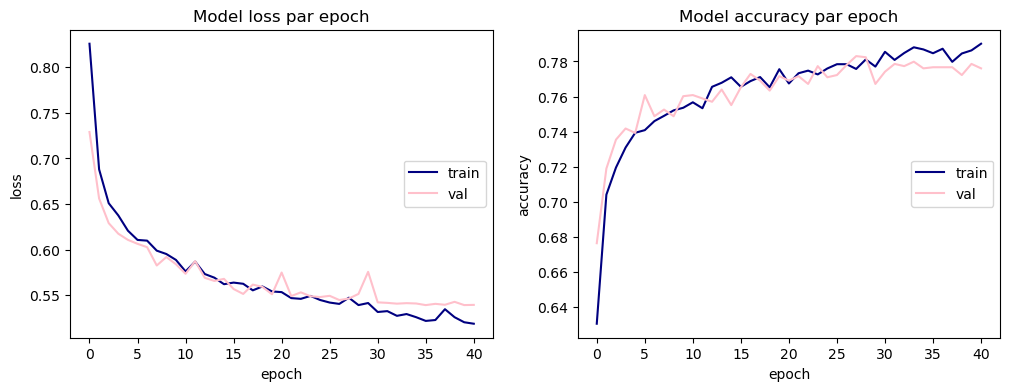

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
              precision    recall  f1-score   support

        Sain       0.78      0.84      0.81       524
       Covid       0.75      0.74      0.74       524
      Autres       0.80      0.76      0.78       524

    accuracy                           0.78      1572
   macro avg       0.78      0.78      0.78      1572
weighted avg       0.78      0.78      0.78      1572



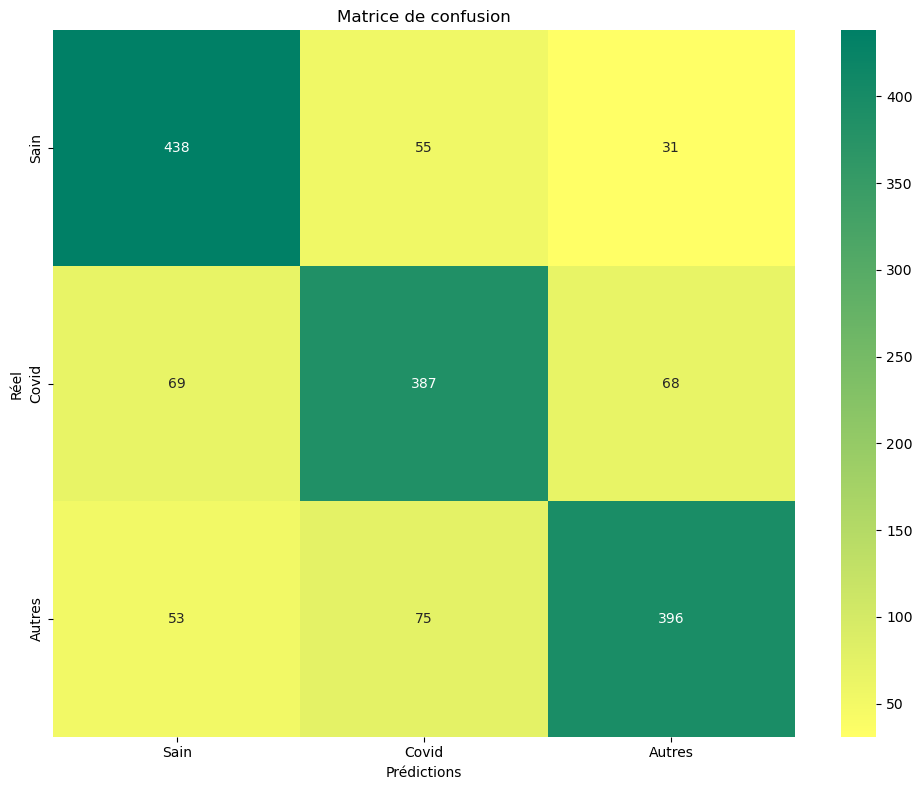

In [25]:
# Visualisation des courbes de loss et d'accuracy
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'], color='navy')
plt.plot(history.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'], color='navy')
plt.plot(history.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# Visualisation du rapport de classification et de la matrice de confusion
noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred, target_names=noms))
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Les scores ne sont pas catastrophiques, on a un équilibre des scores entre les trois classes ce qui témoigne d'un plutôt bon apprentissage. Pas de gros écart entre l'évolution de l'accuracy et de la loss entre les courbes d'entrainement et de validation ce qui implique qu'il n'y a, à priori, pas d'overfitting.
Le modèle suivant est sauvegardé comme point de départ avant de procéder au fine-tuning afin d'améliorer les performances. 

In [28]:
# Sauvegarde du modèle de base
model.save("inceptionv3_covid_baseline.keras")

Dans l'article, il n'est pas mentionné le nombre de couches dégelées. Nous avons donc choisi un nombre en prenant en compte uniquement les couches supérieures qui concernent les filtres les plus spécialisées afin de les adapter à notre jeu de données ainsi que les propriétés techniques limitées de l'ordinateur (CPU). Ce nombre est fixé à 50 couches dans un premier temps, puis sera modifié selon les performances observées lors du fine-tuning.

In [9]:
model = keras.models.load_model("inceptionv3_covid_baseline.keras")

for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))

0 input_layer_5 <class 'keras.src.layers.core.input_layer.InputLayer'>
1 resizing_2 <class 'keras.src.layers.preprocessing.image_preprocessing.resizing.Resizing'>
2 inception_v3 <class 'keras.src.models.functional.Functional'>
3 global_average_pooling2d_2 <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
4 dropout_1 <class 'keras.src.layers.regularization.dropout.Dropout'>
5 dense_1 <class 'keras.src.layers.core.dense.Dense'>


In [13]:
# fine-tuning du modèle en dégelant 50 couches
base_model = model.layers[2]

for layer in base_model.layers[-50:]:
    layer.trainable=True

for i, layer in enumerate(base_model.layers[-50:]):
    print(i, layer.name, layer.trainable)

checkpoint = ModelCheckpoint("inceptionV3_covid_finetuned.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

0 conv2d_271 True
1 average_pooling2d_25 True
2 conv2d_264 True
3 batch_normalization_266 True
4 batch_normalization_267 True
5 batch_normalization_270 True
6 batch_normalization_271 True
7 conv2d_272 True
8 batch_normalization_264 True
9 activation_266 True
10 activation_267 True
11 activation_270 True
12 activation_271 True
13 batch_normalization_272 True
14 activation_264 True
15 mixed9_0 True
16 concatenate_4 True
17 activation_272 True
18 mixed9 True
19 conv2d_277 True
20 batch_normalization_277 True
21 activation_277 True
22 conv2d_274 True
23 conv2d_278 True
24 batch_normalization_274 True
25 batch_normalization_278 True
26 activation_274 True
27 activation_278 True
28 conv2d_275 True
29 conv2d_276 True
30 conv2d_279 True
31 conv2d_280 True
32 average_pooling2d_26 True
33 conv2d_273 True
34 batch_normalization_275 True
35 batch_normalization_276 True
36 batch_normalization_279 True
37 batch_normalization_280 True
38 conv2d_281 True
39 batch_normalization_273 True
40 activation_2

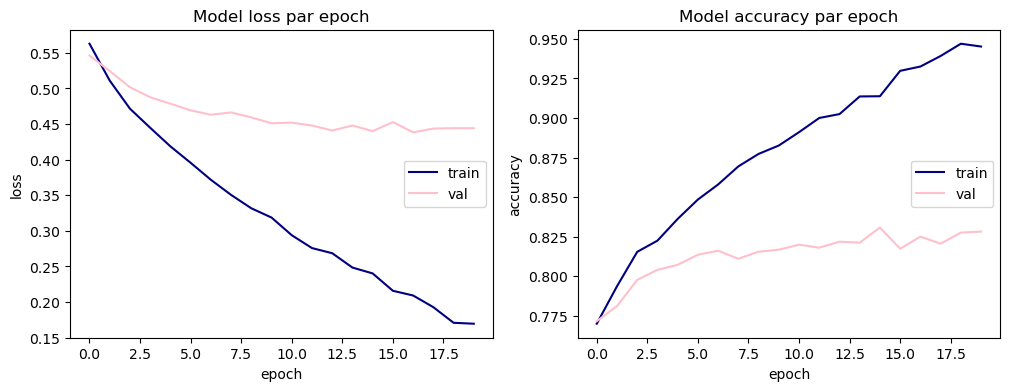

50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step
              precision    recall  f1-score   support

        Sain       0.82      0.89      0.85       524
       Covid       0.83      0.79      0.81       524
      Autres       0.83      0.79      0.81       524

    accuracy                           0.83      1572
   macro avg       0.83      0.83      0.82      1572
weighted avg       0.83      0.83      0.82      1572



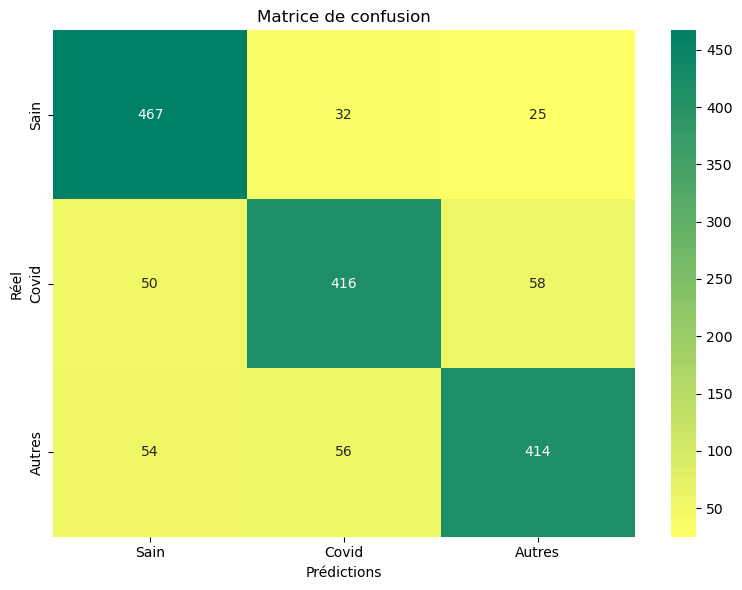

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_ft.history['loss'], color='navy')
plt.plot(history_ft.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_ft.history['accuracy'], color='navy')
plt.plot(history_ft.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba_ft = model.predict(X_val)
y_pred_ft = np.argmax(y_pred_proba_ft, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred_ft, target_names=noms))
cm_ft = confusion_matrix(y_val, y_pred_ft)

plt.figure(figsize=(8,6))
sns.heatmap(cm_ft, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

L'accuracy a bien été améliorée mais on constate un overfiting, en effet, l'accuracy et la val_accuracy ont un écart d'environ 10%. Lorsque l'on observe la courbe de la loss et de l'accuracy de l'ensemble d'entrainement, on voit que le modèle continu d'apprendre mais probablement sur des détails ce qui conduit au sur-apprentissage. D'où l'écart qui se creuse entre l'ensemble d'entrainement et l'ensemble de validation.
Nous allons donc réduire le nombre de couches dégelée et observer s'il y a une amélioration.

In [16]:
# fine-tuning du modèle en dégelant 20 couches
model_ft2 = keras.models.load_model("inceptionv3_covid_baseline.keras")

base_model = model_ft2.layers[2]

for layer in base_model.layers[-20:]:
    layer.trainable=True

for i, layer in enumerate(base_model.layers[-20:]):
    print(i, layer.name, layer.trainable)

checkpoint = ModelCheckpoint("inceptionV3_covid_finetuned_20layers.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model_ft2.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft2 = model_ft2.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

0 conv2d_279 True
1 conv2d_280 True
2 average_pooling2d_26 True
3 conv2d_273 True
4 batch_normalization_275 True
5 batch_normalization_276 True
6 batch_normalization_279 True
7 batch_normalization_280 True
8 conv2d_281 True
9 batch_normalization_273 True
10 activation_275 True
11 activation_276 True
12 activation_279 True
13 activation_280 True
14 batch_normalization_281 True
15 activation_273 True
16 mixed9_1 True
17 concatenate_5 True
18 activation_281 True
19 mixed10 True
Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.7793 - loss: 0.5305 - val_accuracy: 0.7863 - val_loss: 0.5320 - learning_rate: 1.0000e-04
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.7836 - loss: 0.5298 - val_accuracy: 0.7888 - val_loss: 0.5268 - learning_rate: 1.0000e-04
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.7888 - loss: 0.5201 - val_accuracy: 0.7907 - val_loss: 0.5210 - learning_rate: 1.0000e-04
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/s

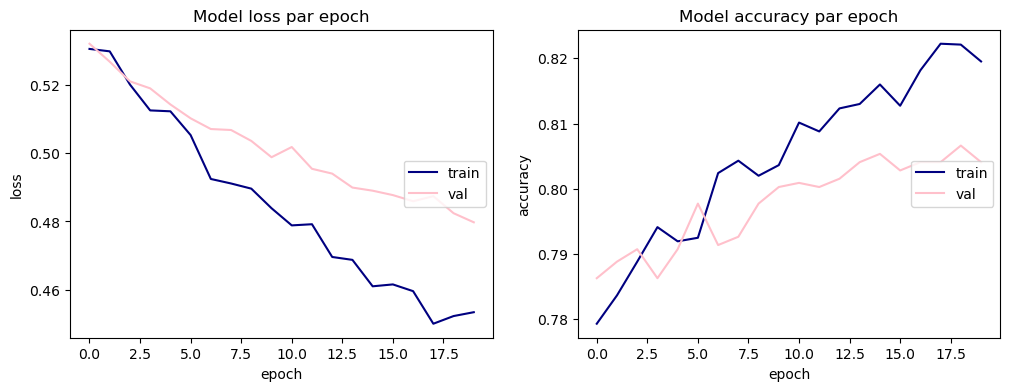

50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step
              precision    recall  f1-score   support

        Sain       0.80      0.86      0.83       524
       Covid       0.79      0.78      0.79       524
      Autres       0.82      0.77      0.80       524

    accuracy                           0.80      1572
   macro avg       0.80      0.80      0.80      1572
weighted avg       0.80      0.80      0.80      1572



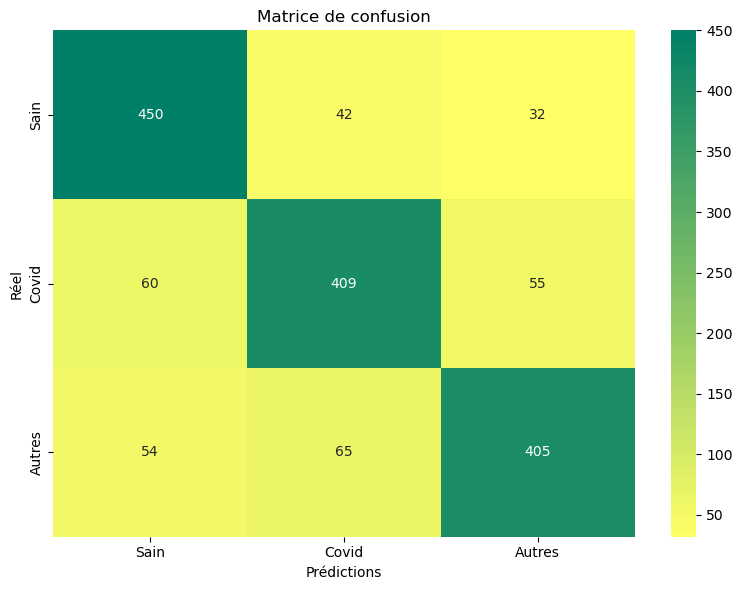

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_ft2.history['loss'], color='navy')
plt.plot(history_ft2.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_ft2.history['accuracy'], color='navy')
plt.plot(history_ft2.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba_ft2 = model_ft2.predict(X_val)
y_pred_ft2 = np.argmax(y_pred_proba_ft2, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred_ft2, target_names=noms))
cm_ft2 = confusion_matrix(y_val, y_pred_ft2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_ft2, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Les resultats sont légerement moins bons puisque comme on peut le voir sur les courbes le modèle n'a pas fini d'apprendre. L'écart entre l'ensemble d'entrainement et l'ensemble de validation est petit, il n'y a pas encore d'overfiting. Nous allons donc lancer un calcul à partir du meilleur score sur 80 epochs afin d'arriver en tout à 100 epochs comme dans l'article.

In [7]:
# prolongement des epochs du meilleur modèle
model_ft3 = keras.models.load_model("inceptionV3_covid_finetuned_20layers.keras")

checkpoint = ModelCheckpoint("inceptionV3_covid_finetuned_20layers_v2.keras",
                             monitor = 'val_loss',
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               min_lr = 1e-6,
                               patience = 3,
                               factor = 0.2)

model_ft3.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft3 = model_ft3.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=80, batch_size=32,
                    callbacks = [checkpoint, earlystop, reduce_lr])

Epoch 1/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 762s 3s/step - accuracy: 0.8255 - loss: 0.4424 - val_accuracy: 0.8053 - val_loss: 0.4794 - learning_rate: 1.0000e-04
Epoch 2/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 714s 3s/step - accuracy: 0.8248 - loss: 0.4373 - val_accuracy: 0.8047 - val_loss: 0.4806 - learning_rate: 1.0000e-04
Epoch 3/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.8242 - loss: 0.4405 - val_accuracy: 0.8060 - val_loss: 0.4839 - learning_rate: 1.0000e-04
Epoch 4/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.8267 - loss: 0.4396 - val_accuracy: 0.8085 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 5/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.8312 - loss: 0.4315 - val_accuracy: 0.8066 - val_loss: 0.4765 - learning_rate: 1.0000e-04
Epoch 6/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - accuracy: 0.8356 - loss: 0.4308 - val_accuracy: 0.8092 - val_loss: 0.4716 - learning_rate: 1.0000e-04
Epoch 7/80
230/230 ━━━━━━━━━━━━━━━━━━━━ 628s 3s/step - acc

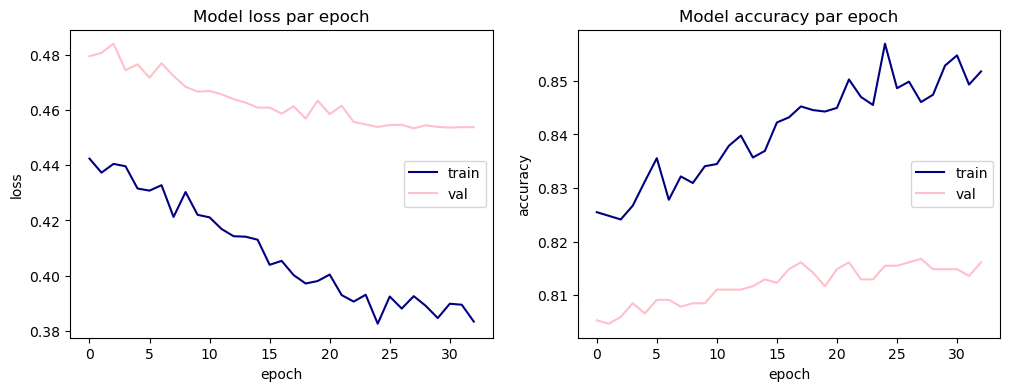

50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step
              precision    recall  f1-score   support

        Sain       0.80      0.89      0.84       524
       Covid       0.81      0.79      0.80       524
      Autres       0.84      0.78      0.81       524

    accuracy                           0.82      1572
   macro avg       0.82      0.82      0.82      1572
weighted avg       0.82      0.82      0.82      1572



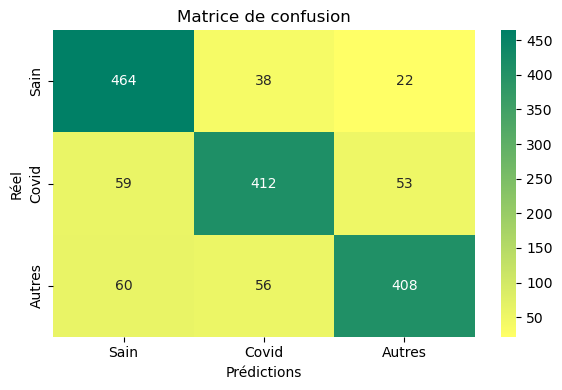

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_ft3.history['loss'], color='navy')
plt.plot(history_ft3.history['val_loss'], color='pink')
plt.title('Model loss par epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_ft3.history['accuracy'], color='navy')
plt.plot(history_ft3.history['val_accuracy'], color='pink')
plt.title('Model accuracy par epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

y_pred_proba_ft3 = model_ft3.predict(X_val)
y_pred_ft3 = np.argmax(y_pred_proba_ft3, axis=1)

noms = ["Sain","Covid", "Autres"]
print(classification_report(y_val, y_pred_ft3, target_names=noms))
cm_ft3 = confusion_matrix(y_val, y_pred_ft3)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ft3, annot=True,
            fmt='d',
            cmap='summer_r',
            xticklabels=noms,
            yticklabels=noms)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Les résultats ne sont pas beaucoup améliorés. On évalue le modèle sur l'ensemble de test :

50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8279 - loss: 0.4550
Test loss : 0.4550
Test accuracy : 0.8279
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
              precision    recall  f1-score   support

        Sain       0.82      0.88      0.85       525
       Covid       0.81      0.80      0.80       525
      Autres       0.86      0.81      0.83       525

    accuracy                           0.83      1575
   macro avg       0.83      0.83      0.83      1575
weighted avg       0.83      0.83      0.83      1575



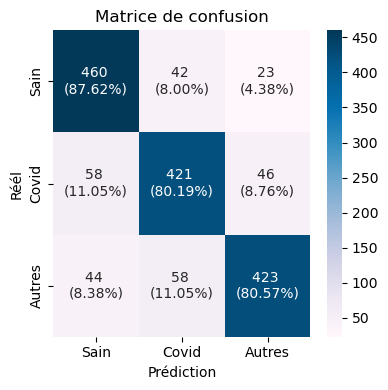

In [12]:
# Evaluation du meilleur modèle
model = load_model("inceptionV3_covid_finetuned_20layers_v2.keras")
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test loss : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

y_proba = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_proba, axis=1)

noms_classes = ["Sain", "Covid", "Autres"]
print(classification_report(y_test, y_pred, target_names=noms_classes))

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm/cm.sum(axis=1, keepdims=True)

labels = np.array([[f"{cm[i,j]} \n({cm_norm[i,j]*100:.2f}%)" for j in range(len(cm))] for i in range(len(cm))])

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=labels, fmt="", cmap="PuBu", xticklabels=noms_classes, yticklabels=noms_classes)
plt.xlabel('Prédiction')
plt.ylabel('Réél')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

Les résultats sur l'ensemble de test sont satisfaisants avec une accuracy globale de 83%.

La classe "Sain" est la mieux classée avec 460 bonnes prédictions et un recall de 88% indique que le modèle génère peu de faux négatifs.
Pour les classes "Covid" et "Autres" les performances sont également correctes.
La classe "Autres", notament, est bien reconnue (86% de précision), ce qui montre que le modèle se trompe peu lorsqu'il la prédit.

Globalement, le modèle généralise bien. Les différences avec les résultats de l'article duquel nous nous inspirons s'expliquent : 
* Ils utilisent InceptionV4 tandis que nous utilisons InceptionV3.
* Leur classification comporte 2 classes uniquement("Sain" vs "Covid"), alors que nous avons 3 classes ("Sain", "Covid" et "Autres")
* Les catégories "Covid" et "Autres présentent une forte similarité visuelle ce qui augmente la difficulté du modèle.

Malgré cela, InceptionV3 offre des performances assez bonnes.
Pour tenter d'améliorer ces résultats, nous allons explorer l'optimiseur Adam.

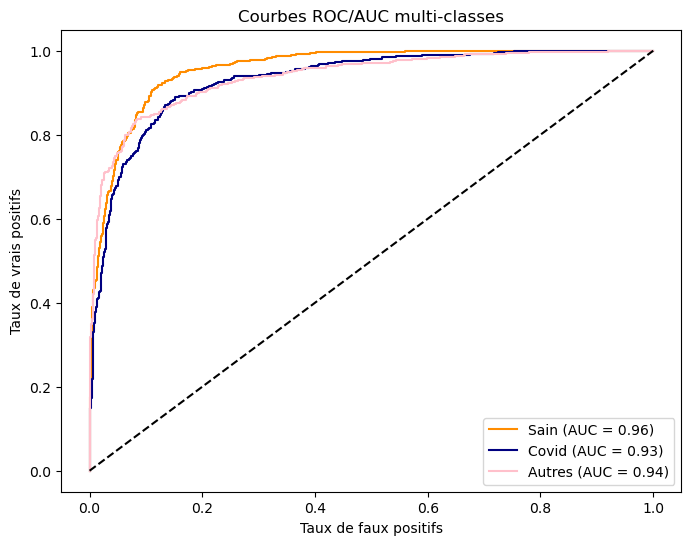

In [9]:
# Les courbes ROC/AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = [0,1,2]
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_proba[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))

colors = ["darkorange", "navy", "pink"]
labels = ["Sain", "Covid", "Autres"]

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], "k--")

plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC/AUC multi-classes')
plt.legend()
plt.show()

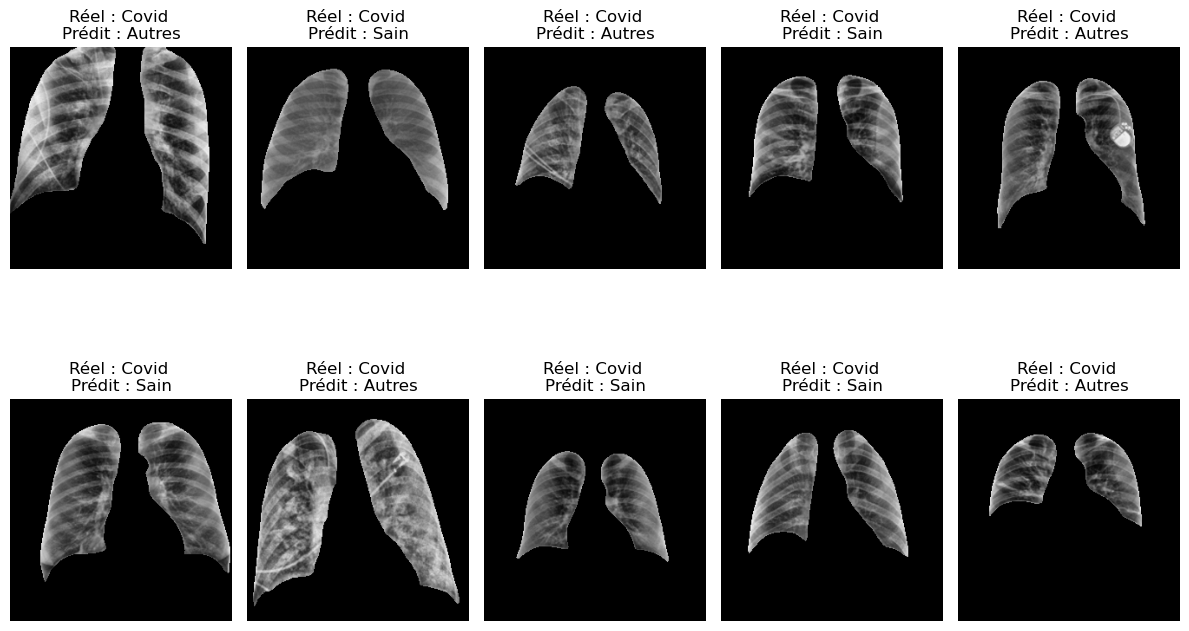

In [13]:
# Visualisation des erreurs du modèle sur la classe Covid-19
label_map = {0 : "Sain", 1 : "Covid", 2 : "Autres"}
covid_label = 1

idx_mis_covid = np.where((y_test == covid_label) & (y_pred != covid_label))[0]

sample_idx = idx_mis_covid[:10]
fig, axes = plt.subplots(2,5,figsize=(12, 8))
for ax, i in zip(axes.flat, sample_idx):
    img = (X_test[i] +1)/2
    ax.imshow(img.squeeze(), cmap="gray")
    real_label = label_map[y_test[i]]
    pred_label = label_map[y_pred[i]]
    ax.set_title(f"Réel : {real_label} \nPrédit : {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()